In [1]:
import datetime
import pickle
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tools.eval_measures import rmse

---
# Sales Forecasting In An Online Store

---
## 1. Introduction

I am using a public dataset from Kaggle, which can be found [HERE](https://www.kaggle.com/datasets/shriyashjagtap/e-commerce-customer-for-behavior-analysis).

Forecasting future sales is a key component of effective business management. It provides companies with the ability to better understand what to expect in the future, which in turn helps them plan their resources and strategies more effectively. One of the primary benefits of forecasting is the optimization of production and marketing costs.

Sales forecasts are extremely useful for strategic decision-making. They help businesses identify which products are most popular, which categories require more attention, and where marketing efforts should be focused.

With the advancement of technology, machine learning provides powerful tools for analysis and forecasting. In this notebook, we will demonstrate how to use Python to create models that predict future sales based on historical data. We will explore how to prepare the data, build the model, and evaluate its accuracy. Even with limited data or missing values, machine learning can offer valuable insights and help companies remain competitive in the market.

---
## 2. Data Ingestion And Preprocessing
Since we are using a regression approach to predict the purchase amount, we need to clean and prepare the data for analysis.

The goal of the data preprocessing stage is to minimize potential errors in the model. As a rule, a model is only as good as the data fed into it, and data preprocessing ensures that the model works with the most accurate dataset possible. While we cannot clean the data perfectly, we can follow basic steps to provide the best foundation for building an accurate model.

First, let's check for the presence of null values in the dataset. Null values are records that are missing or useless for our analysis. If we fail to remove these values, the model will be inaccurate because it will create "connections" to unnecessary values instead of focusing on building meaningful relationships.

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
dataset = pd.read_csv('dataset/ecommerce_data.csv')

dataset = dataset.dropna()

dataset['Purchase Date'] = pd.to_datetime(dataset['Purchase Date'], errors='coerce')

dataset['Year-Month'] = dataset['Purchase Date'].dt.to_period('M')

last_month = dataset['Year-Month'].max()

filtered_data = dataset[dataset['Year-Month'] != last_month]

dataset = filtered_data.drop(columns=['Year-Month'])

In [4]:
dataset.tail()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
202613,39806,2021-08-01 04:43:12,Electronics,225,5,5293,Credit Card,60,0.0,Dana Brown,60,Female,0
202614,33807,2023-01-24 12:32:18,Home,436,1,3664,Cash,63,0.0,Gabriel Williams,63,Male,0
202615,20455,2021-06-04 05:45:25,Electronics,233,1,4374,Credit Card,66,1.0,Barry Foster,66,Female,0
202616,15023,2021-06-27 14:42:12,Electronics,44,2,2517,Cash,64,1.0,Melissa Fernandez,64,Male,0
202617,4148,2020-09-07 05:12:19,Home,307,5,3634,Cash,32,0.0,Angela Norton,32,Male,0


In [5]:
dataset['Total Purchase Amount'].describe()

count    200678.000000
mean       2725.921446
std        1442.171692
min         100.000000
25%        1478.000000
50%        2727.000000
75%        3974.000000
max        5350.000000
Name: Total Purchase Amount, dtype: float64

In [6]:
dataset['Year-Month'] = dataset['Purchase Date'].dt.to_period('M')

monthly_sales = dataset.groupby('Year-Month')['Total Purchase Amount'].sum().reset_index()
monthly_sales.columns = ['Month', 'Total Sales']

In [7]:
monthly_sales.head(10)

,Month,Total Sales
0,2020-01,12567493
1,2020-02,11821574
2,2020-03,12556688
3,2020-04,12257415
4,2020-05,12664133
5,2020-06,12242023
6,2020-07,12456787
7,2020-08,13003738
8,2020-09,12281744
9,2020-10,12979568


In [8]:
dataset['Year'] = dataset['Purchase Date'].dt.to_period('Y')

yearly_sales = dataset.groupby('Year')['Total Purchase Amount'].sum().reset_index()
yearly_sales.columns = ['Year', 'Total Sales']

In [9]:
yearly_sales.head()

,Year,Total Sales
0,2020,149935759
1,2021,148790204
2,2022,149461069
3,2023,98845432


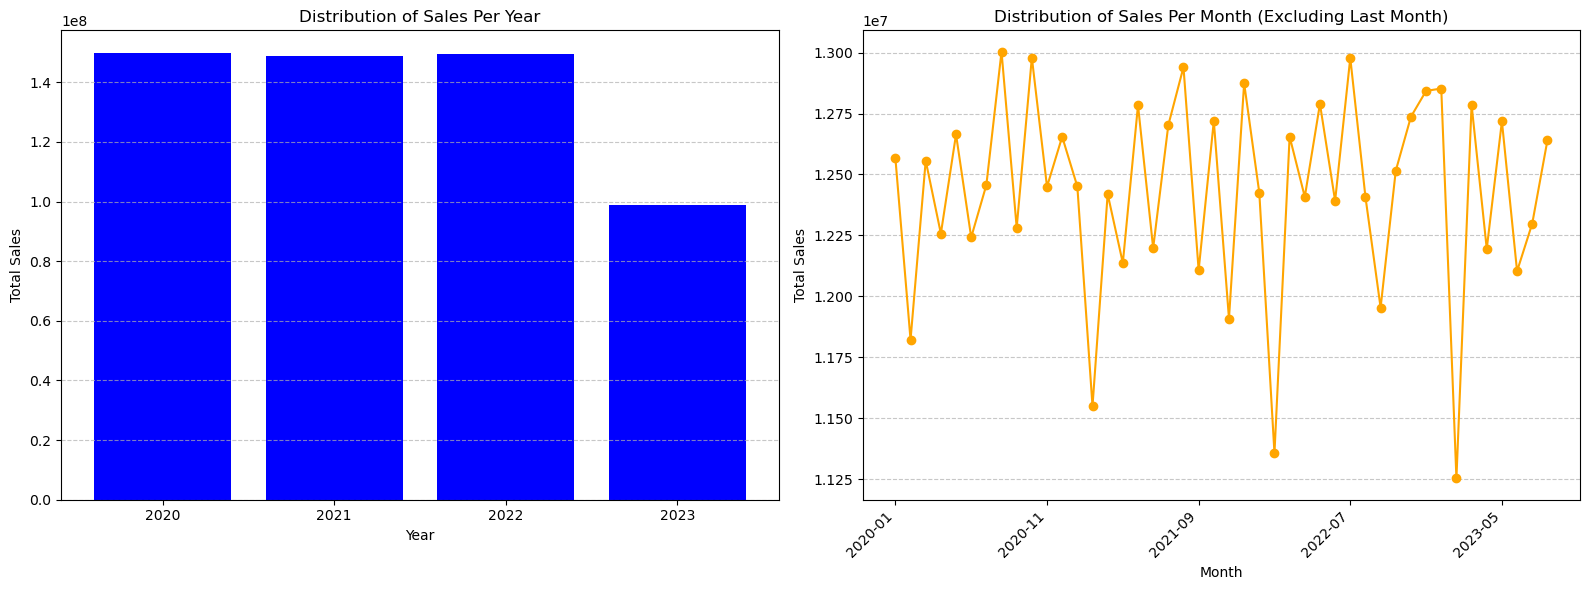

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(yearly_sales['Year'].astype(str), yearly_sales['Total Sales'], color='blue')
axes[0].set_title('Distribution of Sales Per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Sales')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].plot(monthly_sales['Month'].astype(str), monthly_sales['Total Sales'], marker='o', color='orange')
axes[1].set_title('Distribution of Sales Per Month (Excluding Last Month)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Sales')
tick_positions = range(0, len(monthly_sales), 10)
axes[1].set_xticks(tick_positions)
axes[1].set_xticklabels(monthly_sales['Month'].astype(str).iloc[tick_positions], rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

---
## 3. EDA
The goal of EDA (Exploratory Data Analysis) is to improve our understanding of trends in the dataset without using complex machine learning models. Often, we can notice obvious relationships and characteristics by using graphs and charts created through visualizing the columns in the dataset against each other.

To make the data stationary, we will calculate the difference in sales for each month.

Additional details on stationarity and differences can be found here. But first, let's take a closer look at the dataset we are working with to learn more about the data itself.


In [11]:
average_m_sales = monthly_sales['Total Sales'].mean()
print(f"Overall Avarage Monthly Sales: ${average_m_sales}")

def avarage_12months():
    average_m_sales_1y = monthly_sales['Total Sales'][-12:].mean()
    print(f"Last 12 months average monthly sales: ${average_m_sales_1y}")
    
avarage_12months()

Overall Avarage Monthly Sales: $12432556.0
Last 12 months average monthly sales: $12407819.833333334


---
## 4. Data Preparation for Modeling
For time series analysis and preparing data for modeling, calculating the differences in monthly sales is a step toward assessing the stationarity of the series. By using a difference transformation (diff transformation), the trend is removed, making the time series more stable and closer to stationary. After calculating these differences, the average value for each month shows whether stable patterns or seasonality exist in the data. Visualizing the differences helps evaluate whether they remain consistent over time, which is crucial for determining stationarity. If the data appears chaotic but with consistent amplitude, this indicates that the series has become stationary. 

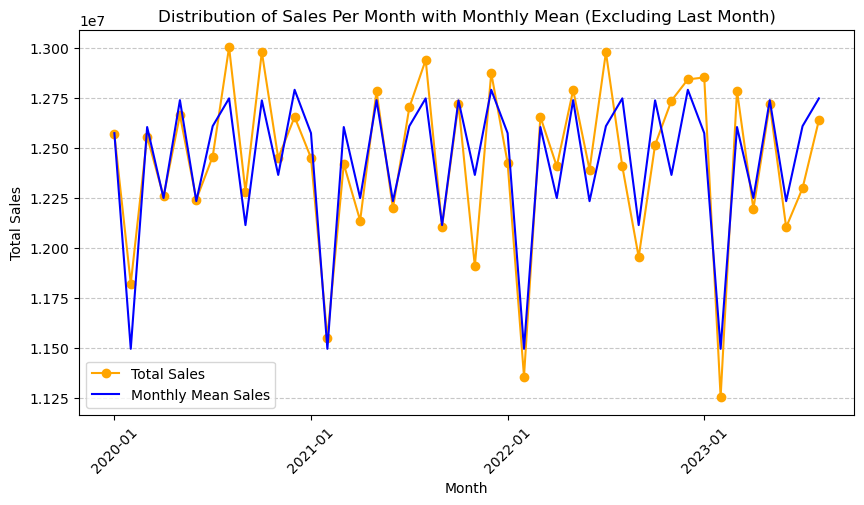

In [12]:
monthly_sales['Monthly Mean Sales'] = monthly_sales.groupby(monthly_sales['Month'].dt.month)['Total Sales'].transform('mean')

plt.figure(figsize=(10, 5))
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['Total Sales'], marker='o', color='orange', label='Total Sales')
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['Monthly Mean Sales'], linestyle='-', color='blue', label='Monthly Mean Sales')

plt.title('Distribution of Sales Per Month with Monthly Mean (Excluding Last Month)')
plt.xlabel('Month')
plt.ylabel('Total Sales')

tick_positions = range(0, len(monthly_sales), 12)
plt.xticks(tick_positions, monthly_sales['Month'].astype(str).iloc[tick_positions], rotation=45)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

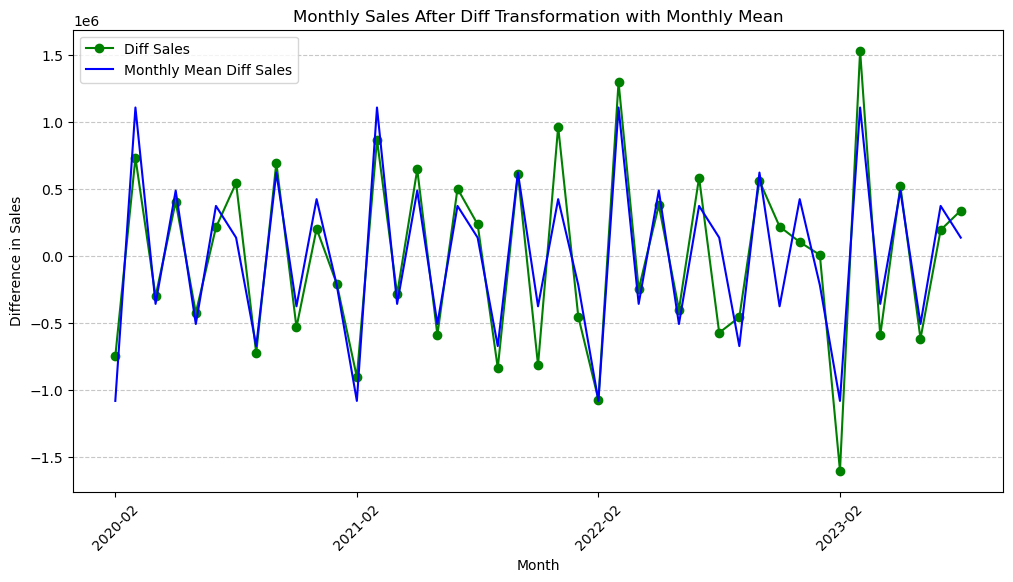

In [13]:
dataset['Year-Month'] = dataset['Purchase Date'].dt.to_period('M')

diff_transformed_sales = dataset.groupby('Year-Month')['Total Purchase Amount'].sum().reset_index()
diff_transformed_sales.columns = ['Month', 'Total Sales']

diff_transformed_sales['Diff Sales'] = diff_transformed_sales['Total Sales'].diff()

diff_transformed_sales['Monthly Mean Diff'] = diff_transformed_sales.groupby(diff_transformed_sales['Month'].dt.month)['Diff Sales'].transform('mean')
diff_transformed_sales = diff_transformed_sales.dropna()

plt.figure(figsize=(12, 6))
plt.plot(diff_transformed_sales['Month'].astype(str), diff_transformed_sales['Diff Sales'], marker='o', color='green', label='Diff Sales')
plt.plot(diff_transformed_sales['Month'].astype(str), diff_transformed_sales['Monthly Mean Diff'], linestyle='-', color='blue', label='Monthly Mean Diff Sales')

plt.title('Monthly Sales After Diff Transformation with Monthly Mean')
plt.xlabel('Month')
plt.ylabel('Difference in Sales')

tick_positions = range(0, len(diff_transformed_sales), 12)
plt.xticks(tick_positions, diff_transformed_sales['Month'].astype(str).iloc[tick_positions], rotation=45)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### ARIMA Modeling

For our ARIMA model, we will only need a time index (datetime index) and the dependent variable (difference in sales) in the columns.

In [14]:
def build_arima_data(data):
    da_data = data.set_index('Month').drop('Total Sales', axis=1).drop('Monthly Mean Diff', axis=1)
    da_data.dropna(axis=0)
    
    return da_data

In [15]:
datatime_df = build_arima_data(diff_transformed_sales)
datatime_df

,Diff Sales
Month,
2020-02,-745919.0
2020-03,735114.0
2020-04,-299273.0
2020-05,406718.0
2020-06,-422110.0
2020-07,214764.0
2020-08,546951.0
2020-09,-721994.0
2020-10,697824.0


## Observing Lags

For our other models, we will create a new table where each feature will represent sales from the previous month. To determine how many months to include in our feature set, we will observe the autocorrelation and partial autocorrelation plots and use the rules for selecting lags in ARIMA modeling. This approach will allow us to maintain a consistent look-back period for both ARIMA models and regression models.

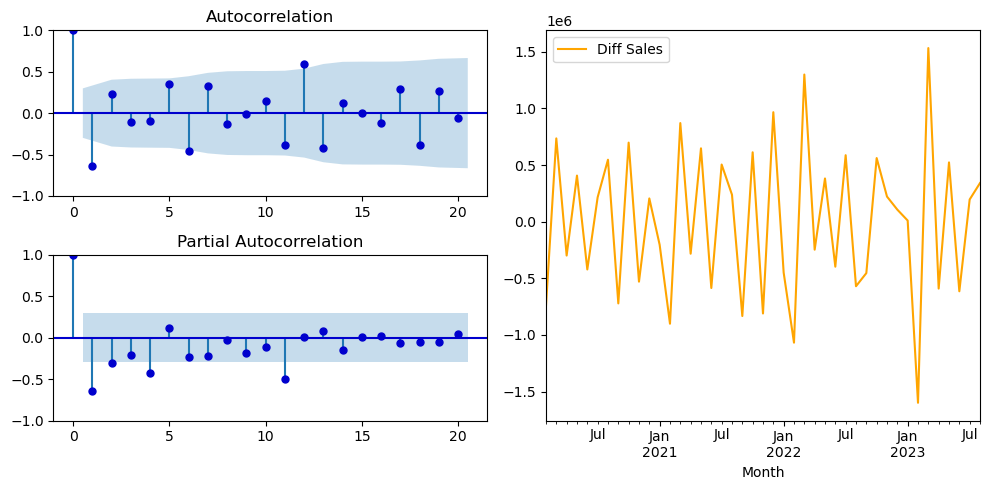

In [16]:
def plots_lag(data, lags=None):
    """Convert dataframe to datetime index"""
    dt_data = data.set_index('Month').drop('Total Sales', axis=1).drop('Monthly Mean Diff', axis=1)
    dt_data.dropna(axis=0)
    
    law  = plt.subplot(122)
    acf  = plt.subplot(221)
    pacf = plt.subplot(223)
    
    dt_data.plot(ax=law, figsize=(10, 5), color='orange')

    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    

    plt.tight_layout()

plots_lag(diff_transformed_sales, lags=20);
    

Based on the above, we will choose our look-back period to be 12 months. Therefore, we will generate a table with one column for each of the 12 months and a column for our dependent variable, the difference in sales.

## Regressive Modeling

Each row represents a month, and the columns will contain sales, dependent variables, and previous sales for each lag. The 12 lagged features will be created based on the data exploration (EDA). The data will be used for regressive modeling.

In [17]:
def built_supervised(data):
    supervised_df = data.copy()

    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['Diff Sales'].shift(i)

    supervised_df = supervised_df.dropna().reset_index(drop=True)

    return supervised_df

In [18]:
model_df = built_supervised(diff_transformed_sales)
model_df 

,Month,Total Sales,Diff Sales,Monthly Mean Diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2021-02,11549281,-901347.0,-1.078832e+06,-204279.0,205218.0,-529879.0,697824.0,-721994.0,546951.0,214764.0,-422110.0,406718.0,-299273.0,735114.0,-745919.0
1,2021-03,12419725,870444.0,1.109315e+06,-901347.0,-204279.0,205218.0,-529879.0,697824.0,-721994.0,546951.0,214764.0,-422110.0,406718.0,-299273.0,735114.0
2,2021-04,12136608,-283117.0,-3.552122e+05,870444.0,-901347.0,-204279.0,205218.0,-529879.0,697824.0,-721994.0,546951.0,214764.0,-422110.0,406718.0,-299273.0
3,2021-05,12783968,647360.0,4.896242e+05,-283117.0,870444.0,-901347.0,-204279.0,205218.0,-529879.0,697824.0,-721994.0,546951.0,214764.0,-422110.0,406718.0
4,2021-06,12198008,-585960.0,-5.051652e+05,647360.0,-283117.0,870444.0,-901347.0,-204279.0,205218.0,-529879.0,697824.0,-721994.0,546951.0,214764.0,-422110.0
5,2021-07,12702344,504336.0,3.753645e+05,-585960.0,647360.0,-283117.0,870444.0,-901347.0,-204279.0,205218.0,-529879.0,697824.0,-721994.0,546951.0,214764.0
6,2021-08,12940243,237899.0,1.388162e+05,504336.0,-585960.0,647360.0,-283117.0,870444.0,-901347.0,-204279.0,205218.0,-529879.0,697824.0,-721994.0,546951.0
7,2021-09,12106899,-833344.0,-6.699063e+05,237899.0,504336.0,-585960.0,647360.0,-283117.0,870444.0,-901347.0,-204279.0,205218.0,-529879.0,697824.0,-721994.0
8,2021-10,12719307,612408.0,6.239377e+05,-833344.0,237899.0,504336.0,-585960.0,647360.0,-283117.0,870444.0,-901347.0,-204279.0,205218.0,-529879.0,697824.0
9,2021-11,11908382,-810925.0,-3.731167e+05,612408.0,-833344.0,237899.0,504336.0,-585960.0,647360.0,-283117.0,870444.0,-901347.0,-204279.0,205218.0,-529879.0


In [19]:
model_df["Month"]

0     2021-02
1     2021-03
2     2021-04
3     2021-05
4     2021-06
5     2021-07
6     2021-08
7     2021-09
8     2021-10
9     2021-11
10    2021-12
11    2022-01
12    2022-02
13    2022-03
14    2022-04
15    2022-05
16    2022-06
17    2022-07
18    2022-08
19    2022-09
20    2022-10
21    2022-11
22    2022-12
23    2023-01
24    2023-02
25    2023-03
26    2023-04
27    2023-05
28    2023-06
29    2023-07
30    2023-08
Name: Month, dtype: period[M]

In [20]:
model_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   Month              31 non-null     period[M]
 1   Total Sales        31 non-null     int64    
 2   Diff Sales         31 non-null     float64  
 3   Monthly Mean Diff  31 non-null     float64  
 4   lag_1              31 non-null     float64  
 5   lag_2              31 non-null     float64  
 6   lag_3              31 non-null     float64  
 7   lag_4              31 non-null     float64  
 8   lag_5              31 non-null     float64  
 9   lag_6              31 non-null     float64  
 10  lag_7              31 non-null     float64  
 11  lag_8              31 non-null     float64  
 12  lag_9              31 non-null     float64  
 13  lag_10             31 non-null     float64  
 14  lag_11             31 non-null     float64  
 15  lag_12             31 non-null     float64

Now we have two separate data structures:

Our ARIMA structure, which includes a time index (DateTime index),

Our observed model structure, which includes lags as featues.


## Splitting Data into Training and Test Sets

We split our data so that 20% is used as the test set, while 80% is used for training the model.

In [21]:
def train_test_split(data, test_size=0.2):
    data = data.drop(['Total Sales', 'Month'], axis=1)
    split_index = int(len(data) * (1 - test_size))
    train, test = data[:split_index].values, data[split_index:].values
    return train, test

train, test = train_test_split(model_df, test_size=0.2)
print(f"Shape of Train: {train.shape}\nShape of Test: {test.shape}")

Shape of Train: (24, 14)
Shape of Test: (7, 14)


## Scaling the Data

Using a Min-Max Scaler, we will scale the data so that all our variables fall within the range of -1 to 1.

In [22]:
def scale_data(train_set,test_set):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f"Shape of X Train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X Test: {X_test.shape}\nShape of y Test: {y_test.shape}")

Shape of X Train: (24, 13)
Shape of y Train: (24,)
Shape of X Test: (7, 13)
Shape of y Test: (7,)


---
## 5. Modeling

In this section, we will create and train a model to predict future sales in an online store. Since there are multiple possible algorithms for building the model, we will compare their accuracy after testing and select the one with the best performance.

We start by importing the various regression algorithms we will use for prediction. Then, we proceed to build and train the model.

The algorithms we will use include XGBoost, DecisionTree, RandomForest, LogisticRegression, SVC, and KNeighborsRegressor. We will calculate the Root Mean Squared Error (RMSE) for each of them and select the algorithm with the lowest error for future use.

#### Training Phase:
At this stage, the model "learns" how to differentiate between different cases, similar to a student studying a new topic before an exam.

#### Testing Phase:
Here, we evaluate how the model performs on data for which we already know the correct outcome. In this phase, accuracy results are generated, helping us compare the performance of different algorithms. The analogy would be a real exam where the student demonstrates what they have learned.


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model_scores = {}

def regressive_model(train, test, model, model_name="Regression Model"):
    X_train, y_train = train
    X_test, y_test = test
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model_scores[model_name] = [rmse, mae, r2]
    
    print(f"{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")

    return model

---
## K-Neighbors Regressor

$\hat{y} = \frac{1}{k} \sum_{i=1}^{k} y_i$

### Explanation:
- **$\hat{y}$**: The predicted value for the given input point.
- **$k$**: The number of neighbors, set as a hyperparameter.
- **$y_i$**: The target value of the $i$-th nearest neighbor.
- **Mean value**: The model calculates the prediction as the average of the target values of the $k$ nearest neighbors.

### How it works:
1. **Distance calculation**: The distances between the input point and all points in the training set are calculated (commonly using **Euclidean distance** or another metric).
2. **Selection of nearest neighbors**: The $k$ points with the smallest distances are selected.
3. **Mean value**: The target values of these points are averaged to obtain the predicted value.


In [24]:
trained_model = regressive_model((X_train, y_train), (X_test, y_test), KNeighborsRegressor(), 'K-Neighbors Regressor')

K-Neighbors Regressor Performance:
  RMSE: 0.4647
  MAE: 0.3089
  R² Score: 0.6503


---
## Support Vector Regressor (SVR)

$$
\frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} \max(0, |y_i - (\mathbf{w} \cdot \mathbf{x}_i + b)| - \epsilon)
$$

### Explanation:
- **$ \|w\|^2 $**: Regularization term that controls the complexity of the model.
- **$ C $**: Regularization parameter that balances between the error on the training data and the complexity of the model.
- **$ y_i $**: Actual value for point $ i $.
- **$ \mathbf{x}_i $**: Input features for point $ i $.
- **$ \mathbf{w} $**: Weight vector.
- **$ b $**: Bias.
- **$ \epsilon $**: Tolerance zone where errors are ignored.
- **$ \max(0, |y_i - (\mathbf{w} \cdot \mathbf{x}_i + b)| - \epsilon) $**: Error term that takes into account the deviation outside of $ \epsilon $.

### How it works:
1. **Defining the tolerance zone ($ \epsilon $):**
   - Errors within $ \epsilon $ are not penalized.
2. **Optimization:**
   - The weights $ \mathbf{w} $ and bias $ b $ are optimized to minimize both the regularization term and the errors outside the $ \epsilon $ zone.
3. **Prediction:**
   - The predicted value $ \hat{y} $ is calculated as:
     $$
     \hat{y} = \mathbf{w} \cdot \mathbf{x} + b
     $$

In [25]:
trained_model = regressive_model((X_train, y_train), (X_test, y_test), SVR(), 'Support Vector Regressor')

Support Vector Regressor Performance:
  RMSE: 0.4915
  MAE: 0.4111
  R² Score: 0.6087


---
## Decision Tree Regressor

$ \hat{y} = \frac{1}{n} \sum_{i=1}^{n} y_i $

### Explanation:
- **$ \hat{y} $**: The predicted value for a given input point.
- **$ n $**: The number of observations (data points) in the tree leaf where the point falls.
- **$ y_i $**: The target value of each observation $ i $ in this leaf.

### How it works:
1. **Splitting the data:**
   - The tree splits the data using rules (e.g., feature values) to minimize a specific metric, such as:
     - **Mean Squared Error (MSE):**
       $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y})^2 $
     - **Mean Absolute Error (MAE):**
       $ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}| $

2. **Leaves (Leaf):**
   - When a point falls into a leaf, the prediction is calculated as the mean of all target values in that leaf:
     $ \hat{y} = \frac{1}{n} \sum_{i=1}^{n} y_i $

3. **Optimization:**
   - The tree continues to split until a stopping criterion is reached, such as maximum depth, a minimum number of points in a leaf, or a minium reduction in error.


In [26]:
trained_model = regressive_model((X_train, y_train), (X_test, y_test), DecisionTreeRegressor(), 'Decision Tree')

Decision Tree Performance:
  RMSE: 0.4357
  MAE: 0.3403
  R² Score: 0.6926


---
## Linear Regression

$$
\hat{y} = \mathbf{w} \cdot \mathbf{x} + b
$$

#### Explanation:
- **$ \hat{y} $**: The predicted value.
- **$ \mathbf{w} $**: The weight vector (model coefficients).
- **$ \mathbf{x} $**: The feature vector.
- **$ b $**: The bias (intercept or constant).

#### Error Function (Mean Squared Error):
The linear regression model minimizes the mean squared error (MSE):

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

#### How it works:
1. **Predictions ($ \hat{y} $):**
   - The predicted value $ \hat{y} $ is calculated as a linear combination of the input features and weights.
2. **Training:**
   - The model optimizes the weights $ \mathbf{w} $ and bias $ b $ to minimize the error $ \text{MSE} $.
3. **Application:**
   - After optimization, the model uses the equation:
     $$
     \hat{y} = \mathbf{w} \cdot \mathbf{x} + b
     $$

In [27]:
trained_model = regressive_model((X_train, y_train), (X_test, y_test), LinearRegression(), 'Linear Regression')

Linear Regression Performance:
  RMSE: 0.3341
  MAE: 0.2829
  R² Score: 0.8192


---
## Random Forest Regressor

The Random Forest Regressor combines predictions from multiple individual Decision Trees to provide a final prediction.

### Prediction:
$$
\hat{y} = \frac{1}{T} \sum_{t=1}^{T} \hat{y}_t
$$

### Explanation:
- **$ \hat{y} $**: The final prediction of the Random Forest.
- **$ T $**: The number of trees in the forest.
- **$ \hat{y}_t $**: The prediction from the $ t $-th Decision Tree.

### How it works:
1. **Building multiple Decision Trees:**
   - Random Forest builds $ T $ Decision Trees using random subsets of data (bootstrap sampling) and random subsets of features.

2. **Predictions from each tree:**
   - Each tree $ t $ provides an individual prediction $ \hat{y}_t $.

3. **Combining predictions:**
   - The final prediction $ \hat{y} $ is the mean of predictions from all trees:
     $$
     \hat{y} = \frac{1}{T} \sum_{t=1}^{T} \hat{y}_t
     $$

### Advantages:
- **Stability:** Random Forest reduces overfitting compared to individual Decision Trees.
- **Flexibility:** It can handle both linear and nonlinear dependencies.

In [28]:
trained_model = regressive_model((X_train, y_train), (X_test, y_test), RandomForestRegressor(), 'RandomForest')

RandomForest Performance:
  RMSE: 0.5207
  MAE: 0.3991
  R² Score: 0.5609


---
## XGBoost

XGBoost is a gradient-boosting algorithm that minimizes the loss function by adding new models (weak learners) to correct the errors of previous ones.

### Optimization:
XGBoost minimizes the following objective function:

$$
\mathcal{L}(\phi) = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)
$$

### Explanation:
1. **$\mathcal{L}(\phi)$**: The total loss.
2. **$l(y_i, \hat{y}_i)$**: The loss function between the true value $y_i$ and the predicted value $\hat{y}_i$ (e.g., Mean Squared Error).
3. **$\Omega(f_k)$**: The regularization term that controls the model complexity:
   $$
   \Omega(f_k) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T} w_j^2
   $$
   - $\gamma$: A parameter that controls the number of leaves $T$ in the tree.
   - $\lambda$: A regularization parameter that controls the weights $w_j$.

### Prediction:
The final prediction is the sum of the predictions of all trees:

$$
\hat{y} = \sum_{k=1}^{K} f_k(\mathbf{x})
$$

### How it works:
1. **Initialization:**
   - The model starts with a base prediction $\hat{y}_0$ (e.g., the mean of the target variable).
   
2. **Adding new trees:**
   - At each step $t$, a new tree $f_t$ is added to minimize the residual error from the previous trees:
     $$
     \hat{y}^{(t)} = \hat{y}^{(t-1)} + f_t(\mathbf{x})
     $$

3. **Regularization:**
   - $\Omega(f_k)$ is added to prevent oerfitting and control model complexity.


In [29]:
trained_model = regressive_model((X_train, y_train), (X_test, y_test), XGBRegressor(), 'XGBoost')

XGBoost Performance:
  RMSE: 0.4230
  MAE: 0.3715
  R² Score: 0.7103


ARIMA Modeling

SARIMAX Modeling

We use the statsmodels SARIMAX package to train the model and generate dynamic predictions. The SARIMA model breaks down into a few parts.

- AR: represented as p, is the autoregressive model

- I : represented as d, is the differencing term

- MA: represented as q, is the moving average model

- S: enables us to add a seasonal component

In [30]:
datatime_df.index = datatime_df.index.to_timestamp()
datatime_df.index = pd.to_datetime(datatime_df.index)

In the code below, we define our model and make dynamic forecasts for the last 12 months of the data.

- **Standard, non-dynamic forecasts:** The forecast for the next month is made using the actual sales from previous months.

- **Dynamic forecasts:** The forecast for the next month is made using the predicted sales from previous months.

In [31]:
arima_model_score = {}

def sarimax_model(data):
    data['Diff Sales'] = data['Diff Sales'].interpolate()
    data['Diff Sales'] = data['Diff Sales'].diff().dropna()
    
    sar = sm.tsa.statespace.SARIMAX(data['Diff Sales'], order=(12, 0, 0), seasonal_order=(0, 0, 0, 12), trend='c',enforce_stationarity=False, enforce_invertibility=False ).fit(method='powell')
    
    start, end, dynamic = 30, 42, 7
    data['pred_value'] = sar.predict(start=start, end=end, dynamic=dynamic)
    pred_df = data.pred_value[start+dynamic:end]
    
    data[['Diff Sales',"pred_value"]].plot(color=['blue', 'Red'])
    plt.legend(loc='upper left')
    
    rmse = np.sqrt(mean_squared_error(data['Diff Sales'][-12:], data.pred_value[-12:]))
    mae = mean_absolute_error(data['Diff Sales'][-12:], data.pred_value[-12:])
    r2 = r2_score(data['Diff Sales'][-12:], data.pred_value[-12:])
    arima_model_score['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

    return sar, data, pred_df

Optimization terminated successfully.
         Current function value: 10.085448
         Iterations: 1
         Function evaluations: 118
RMSE: 361246.85000581836
MAE: 287967.19375526713
R2 Score: 0.9262717993002482


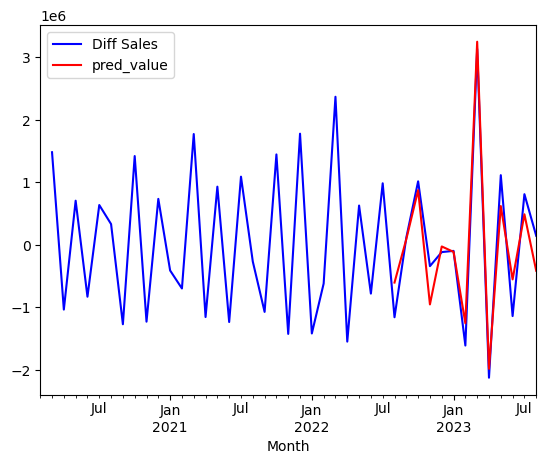

In [32]:
sar, datatime_df, predictions = sarimax_model(datatime_df)

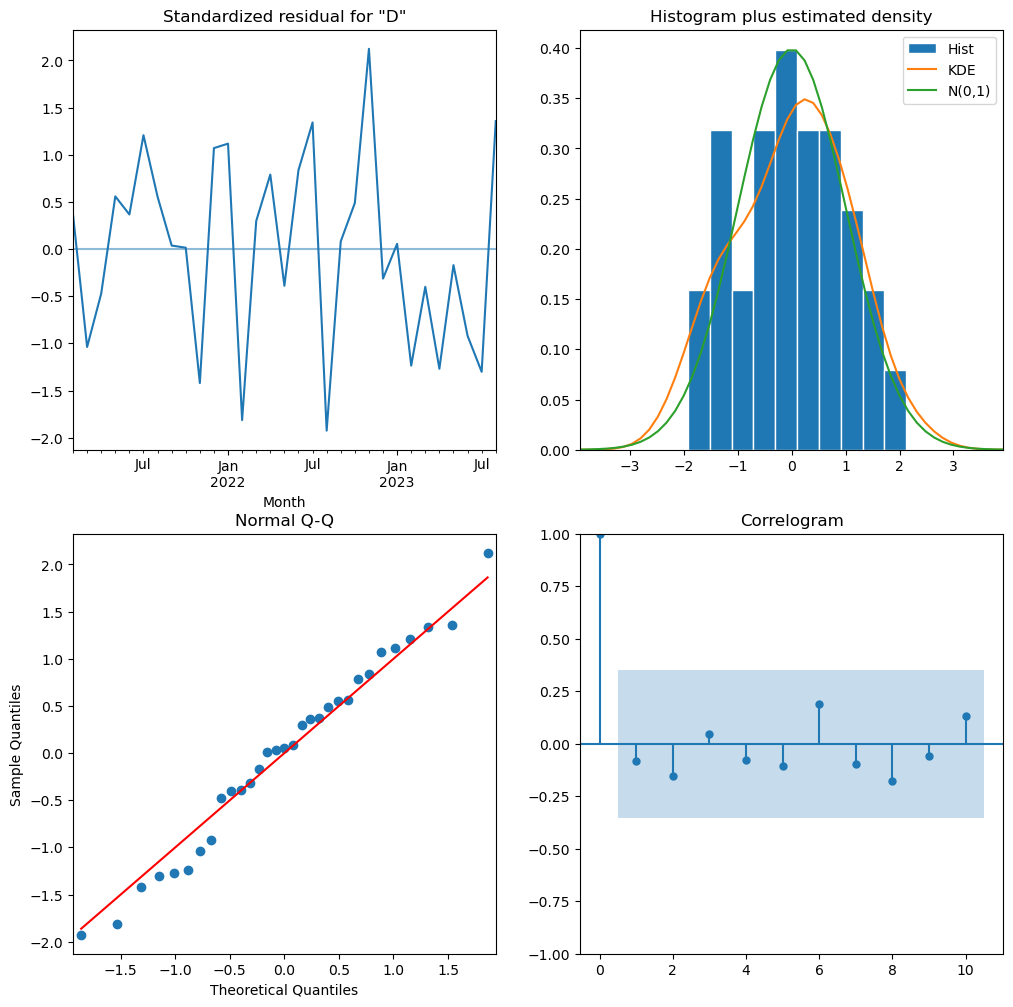

In [33]:
sar.plot_diagnostics(figsize=(12, 12));

---
## 6. Model Comparison

In [34]:
def create_results_df(scores):
    
    results_df = pd.DataFrame.from_dict(scores, orient='index', columns=['RMSE', 'MAE', 'R2'])
    
    results_df = results_df.sort_values(by='RMSE', ascending=False).reset_index()
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    sns.lineplot(x=np.arange(len(results_df)), y='RMSE', data=results_df, ax=ax, 
                 label='RMSE', color='darkblue')
    sns.lineplot(x=np.arange(len(results_df)), y='MAE', data=results_df, ax=ax, 
                 label='MAE', color='cyan')

    plt.xticks(np.arange(len(results_df)), rotation=45)
    ax.set_xticklabels(results_df['index'])
    ax.set(xlabel="Model",
           ylabel="Scores",
           title="Regressive Model Error Comparison")
    sns.despine()
    
    return results_df

,index,RMSE,MAE,R2
0,RandomForest,0.520671,0.399066,0.560910
1,Support Vector Regressor,0.491541,0.411133,0.608667
2,K-Neighbors Regressor,0.464655,0.308880,0.650307
3,Decision Tree,0.435686,0.340265,0.692550
4,XGBoost,0.422957,0.371451,0.710254
5,Linear Regression,0.334084,0.282876,0.819225


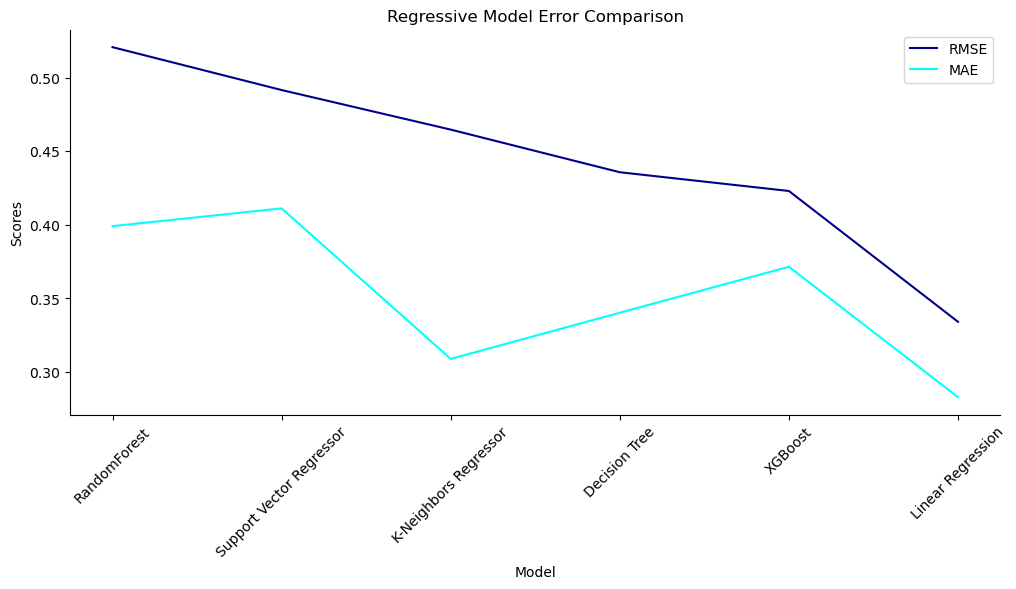

In [35]:
results = create_results_df(model_scores)
results

In [36]:
avarage_12months()

Last 12 months average monthly sales: $12407819.833333334


In [37]:
average = 12407819.833333334
LinearRegression = results.MAE.values[5]
percentage_off = round(LinearRegression/average*100,2)

print(f"With Linear Regression, prediction is within {percentage_off}% of the actual.")

With Linear Regression, prediction is within 0.0% of the actual.


---
## 7. Conclusion
In this notebook, we analyzed data and attempted to predict future sales. We demonstrated the power of data analysis and how it can help make smart business decisions. Instead of relying on guesses and inaccurate survey responses, businesses can simply analyze their own sales data to gain key insights into what works for them and what doesn’t.

The Linear Regression model showed the best performance compared to other models, with the lowest Mean Absolute Error (MAE) of 0.282876, the lowest Root Mean Squared Error (RMSE) of 0.334084, and the highest coefficient of determination (R²) of 0.819225. This makes it the most accurate model for this task.

#### Percentage Deviation:
With an MAE within 0.0% of the average target value, the Linear Regression model demonstrates its efficiency and minimal deviation from actual values.

#### Comparison with Other Models:
While other algorithms, such as XGBoost and RandomForest, also delivered good results, Linear Regression stood out with lower error and better explanatory power, making it suitable for prediction in the context of this data.

#### Business Value:
Accurate predictions from Linear Regression can help businesses better understand customer behavior by providing reliable forecasts for future sales. This enables better decision-making for managing marketing campaigns, optimizing inventory, and targeting specific customer groups.

## References 
1. [ARIMA and SARIMA for Time Series Forecasting - GeeksforGeeks](https://www.geeksforgeeks.org/arima-model-for-time-series-forecasting/)
2. [DataSet](https://www.kaggle.com/datasets/shriyashjagtap/e-commerce-customer-for-behavior-analysis)
3. [Decision Tree Regression - Towards Data Science](https://towardsdatascience.com/decision-tree-regression-models-explained-in-depth-8e773116f333)
4. [Introduction to Linear Regression - Towards Data Science](https://towardsdatascience.com/introduction-to-linear-regression-2f9578f575dc)
5. [Random Forest Regression Explained - GeeksforGeeks](https://www.geeksforgeeks.org/random-forest-regression-in-python/)
6. [Scikit-learn Documentation: K-Neighbors Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
7. [Scikit-learn Documentation: Support Vector Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
8. [XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/)